In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNetB0 model choice
IMG_SIZE = 224
BATCH_SIZE = 32

2025-06-12 12:46:52.432023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 12:46:52.553137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749725212.607025     572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749725212.620966     572 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749725212.729276     572 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
#Unzip the dataset directory
import os
import zipfile

local_zip = 'OASIS_balanced_resized_12000.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [3]:
#Split data into train/validation/test parts

import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Parameters
DATASET_DIR = "./OASIS_balanced_scaled_128px_12000"
SEED = 123
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

# Get all .jpg image file paths and labels
image_paths = []
labels = []

class_names = sorted([
    name for name in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, name))
])
class_indices = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.png')):  # Filter only .jpg and .png files
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_indices[class_name])

# Split dataset: first into temp+test, then temp into train+val
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels,
    test_size=TEST_SPLIT,
    random_state=SEED,
    stratify=labels
)

val_relative_split = VALIDATION_SPLIT / (1.0 - TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_relative_split,
    random_state=SEED,
    stratify=y_temp
)

# Function to create a tf.data.Dataset from paths and labels
def create_dataset(paths, labels, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image.set_shape([None, None, 3])  # Set dynamic shape before resizing
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        return image, tf.one_hot(label, depth=len(class_names))

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
ds_train = create_dataset(X_train, y_train, is_training=True)
ds_valid = create_dataset(X_val, y_val, is_training=False)
ds_test = create_dataset(X_test, y_test, is_training=False)

# Output stats
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print("Classes:", class_names)

I0000 00:00:1749725228.172948     572 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Train samples: 8399
Validation samples: 1801
Test samples: 1800
Number of classes: 4
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
#Split data into train/validation parts

import os

DATASET_DIR = "OASIS_balanced_resized_12000"
VALIDATION_SPLIT = 0.2  # 20% for validation
SEED = 123

ds_train = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    label_mode="categorical",  # One-hot encoding of labels
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

ds_valid = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# Retrieve the number of classes from the dataset
NUM_CLASSES = len(ds_train.class_names)
print("Classes:", ds_train.class_names)

Found 12000 files belonging to 4 classes.
Using 9600 files for training.
Found 12000 files belonging to 4 classes.
Using 2400 files for validation.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


2025-06-12 12:47:13.401715: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


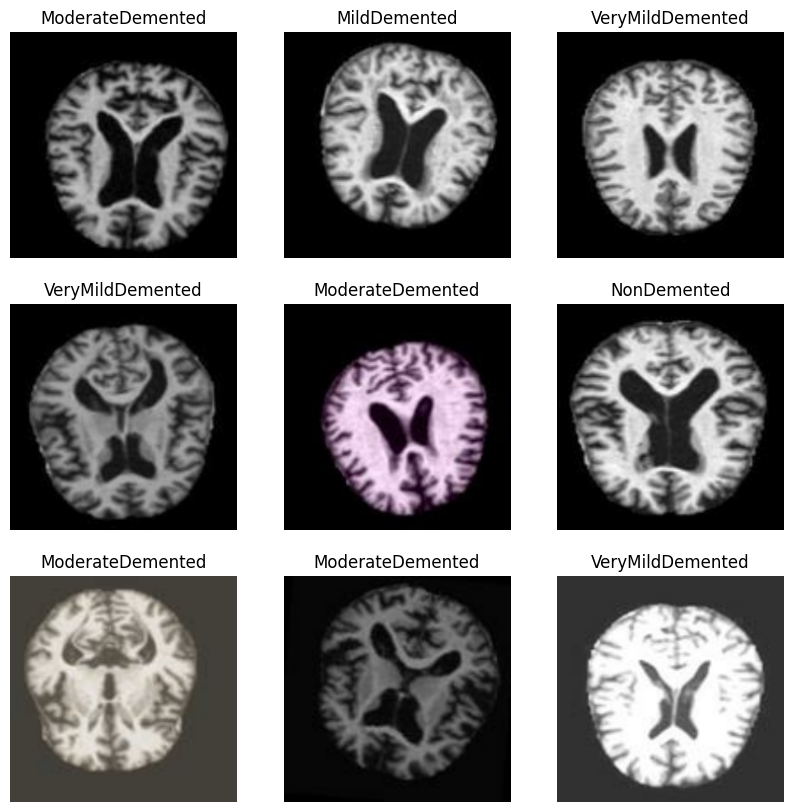

In [ ]:
def format_label(label):
    # Convert the one-hot encoded label to a class index
    class_index = tf.argmax(label).numpy()
    # Return the corresponding class label from the class_labels list
    return class_names[class_index]

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("{}".format(format_label(labels[i])))
        plt.axis("off")

In [ ]:
augmentation_model = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomShear(0.02),  # Reduce shear
    layers.RandomContrast(0.2)
], name="data_augmentation")


def img_augmentation(images):
    return augmentation_model(images)

2025-06-12 12:47:19.792071: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


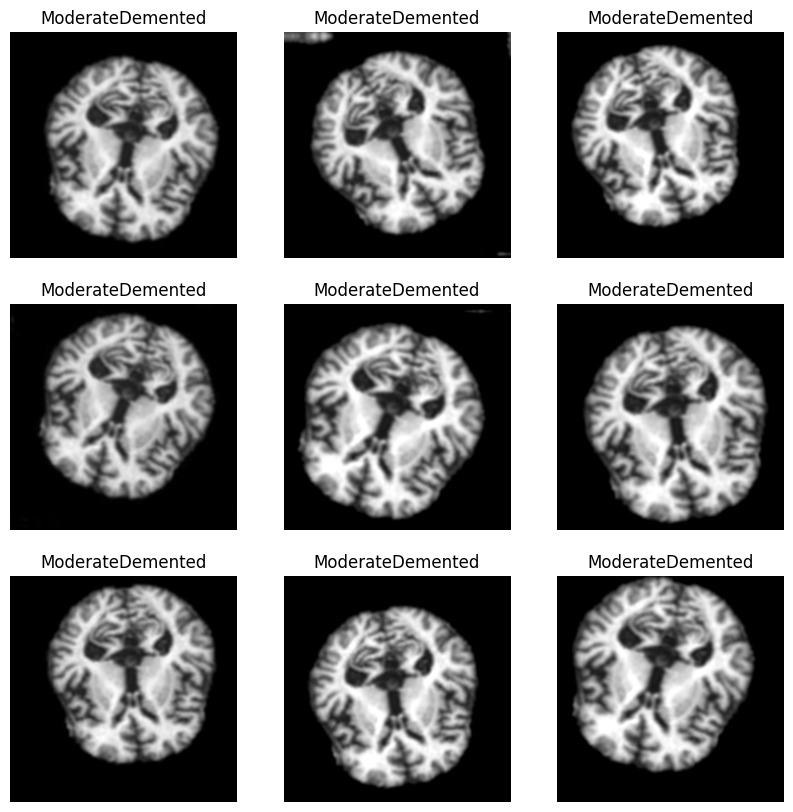

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):  
    for i in range(min(9, images.shape[0])):  
        ax = plt.subplot(3, 3, i + 1)  
        
        # Apply augmentation to each image separately
        augmented_image = img_augmentation(images)[0].numpy().astype("uint8")  

        plt.imshow(augmented_image)  
        plt.title("{}".format(format_label(labels[i])))
        plt.title("{}".format(format_label(labels[0])))
        plt.axis("off")  



In [7]:
#prepare inputs
from keras.applications.efficientnet import preprocess_input

@tf.function
def input_preprocess_train(images, labels):
    images = img_augmentation(images)  # Apply augmentations
    images = preprocess_input(images)  # Apply EfficientNet preprocessing
    return images, labels

def input_preprocess_valid(images, labels):
    images = preprocess_input(images)  # Only preprocessing (no augmentation)
    return images, labels

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_valid = ds_valid.map(input_preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)  

ds_test = ds_test.map(input_preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

print(ds_train)
print(ds_valid)
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


### Transfer learning from pre-trained weights

In [10]:
import matplotlib.pyplot as plt

#Plot Training History
def plot_training_history(hist):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    acc_key = "accuracy" if "accuracy" in hist.history else "categorical_accuracy"
    val_acc_key = "val_" + acc_key

    # Accuracy Plot
    axs[0].plot(hist.history[acc_key])
    axs[0].plot(hist.history[val_acc_key])
    axs[0].set_title("Model Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(["Train", "Validation"], loc="upper left")
    axs[0].grid()

    # Loss Plot
    axs[1].plot(hist.history["loss"])
    axs[1].plot(hist.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(["Train", "Validation"], loc="upper left")
    axs[1].grid()

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(hist):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Determine accuracy key dynamically
    acc_key = "accuracy" if "accuracy" in hist.history else "categorical_accuracy"
    val_acc_key = "val_" + acc_key

    # Accuracy Plot
    axs[0].plot(hist.history[acc_key], label="Train")
    if val_acc_key in hist.history:
        axs[0].plot(hist.history[val_acc_key], label="Validation")
    axs[0].set_title("Model Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="upper left")
    axs[0].grid()

    # Loss Plot
    axs[1].plot(hist.history["loss"], label="Train")
    if "val_loss" in hist.history:
        axs[1].plot(hist.history["val_loss"], label="Validation")
    axs[1].set_title("Model Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper left")
    axs[1].grid()

    # Save plot (optional)
    plt.tight_layout()
    plt.savefig("prema_bozinom_training_history.png", dpi=300)
    plt.show()

In [ ]:
#BUILD A MODEL

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [10]:
for images, labels in ds_train.take(1):
    print(images.shape)  # Should print the shape of a single batch
    break

(32, 224, 224, 3)


2025-06-12 12:47:29.620916: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node StatefulPartitionedCall/data_augmentation_1/random_shear_1/Add_1/_48}}]]
	 [[StatefulPartitionedCall/data_augmentation_1/random_translation_1/Add_1/ReadVariableOp/_44]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-06-12 12:47:29.620966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6587910519623214627
2025-06-12 12:47:29.620974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7004550335425381639
2025-06-12 12:47:29.620980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8767732426715785665
2025-06-12 12:47:29.620986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6083165442338097495
2025-06-12 12:47

Epoch 1/10


I0000 00:00:1749725259.379307   26326 service.cc:152] XLA service 0x2aa76950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749725259.379365   26326 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-06-12 12:47:39.542366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749725260.359565   26326 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/263 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.2367 - loss: 2.0744

I0000 00:00:1749725266.661215   26326 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.3812 - loss: 1.4989 - val_accuracy: 0.5669 - val_loss: 1.0166 - learning_rate: 0.0010
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5397 - loss: 1.0952 - val_accuracy: 0.6191 - val_loss: 0.8739 - learning_rate: 0.0010
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5683 - loss: 1.0246 - val_accuracy: 0.6424 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5900 - loss: 0.9650 - val_accuracy: 0.6430 - val_loss: 0.8259 - learning_rate: 0.0010
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5930 - loss: 0.9511 - val_accuracy: 0.6580 - val_loss: 0.7680 - learning_rate: 0.0010
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5942 - loss: 0.9454 - val_accuracy: 0.6646 - val_loss: 0.7590 - learning_rate: 0.0010
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6042 - loss: 0.9349 - v

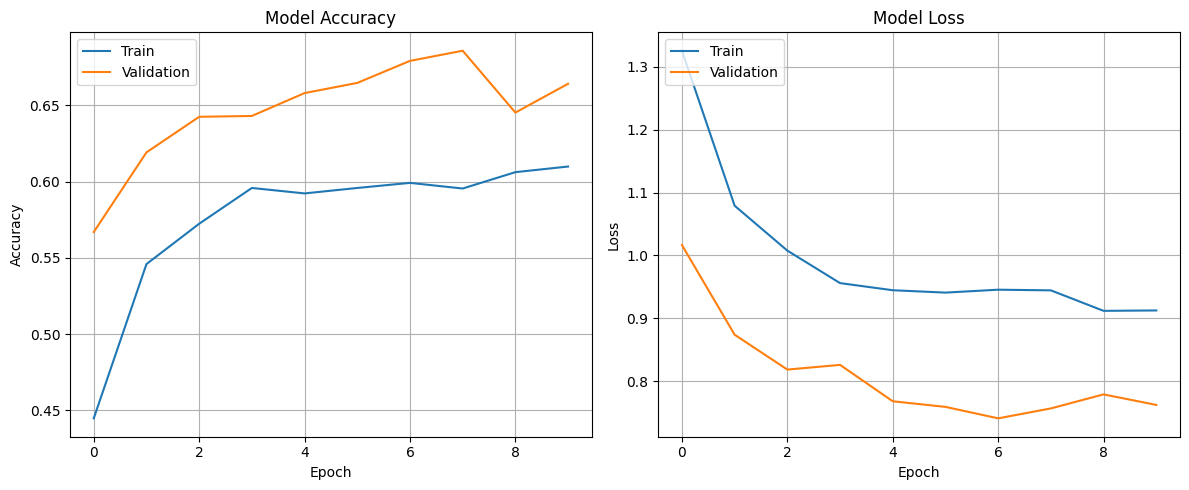

In [ ]:
import time
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import AUC, Precision, Recall

# Build model
model = build_model(num_classes=NUM_CLASSES)

# Set number of epochs (can be adjusted as needed)
epochs = 10  # @param {"type":"slider","min":2,"max":80,"step":1}

#Saves best model
saved_checkpoint = ModelCheckpoint('best_model_phase_1.keras', save_best_only=True)

# Early stopping callback: stops training if validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler: reduces learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Record the start time
start_time = time.time()

# Train the model
hist_phase1 = model.fit(
    ds_train, 
    epochs=epochs, 
    validation_data=ds_valid,
    callbacks=[saved_checkpoint, early_stopping, lr_scheduler]
)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

# Plot training history
plot_training_history(hist_phase1)

In [ ]:
# Evaluate the model on the test dataset
print("Evaluating on test dataset:")
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Evaluating on test dataset:
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6680 - loss: 0.7531
Test Loss: 0.7435730695724487
Test Accuracy: 0.6755555272102356


Epoch 1/15


2025-06-12 12:49:43.832375: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:49:43.959918: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:49:44.092227: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:49:44.226164: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:49:44.360413: E external/local_xla/xla/stream_

261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6235 - loss: 0.8815

2025-06-12 12:50:14.609787: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:50:14.739953: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:50:14.878018: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-12 12:50:15.005480: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


263/263 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - accuracy: 0.6239 - loss: 0.8804 - val_accuracy: 0.7041 - val_loss: 0.6286 - learning_rate: 1.0000e-04
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7382 - loss: 0.6117 - val_accuracy: 0.7507 - val_loss: 0.5356 - learning_rate: 1.0000e-04
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7954 - loss: 0.4790 - val_accuracy: 0.8068 - val_loss: 0.4469 - learning_rate: 1.0000e-04
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8323 - loss: 0.4079 - val_accuracy: 0.8440 - val_loss: 0.3690 - learning_rate: 1.0000e-04
Epoch 5/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8786 - loss: 0.3240 - val_accuracy: 0.8901 - val_loss: 0.2679 - learning_rate: 1.0000e-04
Epoch 6/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8950 - loss: 0.2707 - val_accuracy: 0.8745 - val_loss: 0.2957 - learning_rate: 1.0000e-04
Epoch 7/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accura

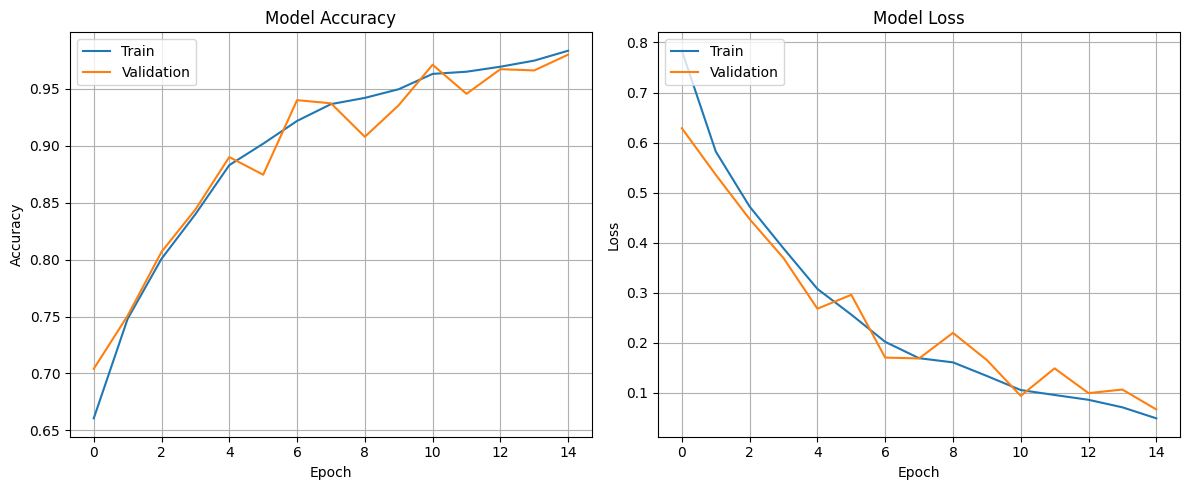

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    #for layer in model.layers[-5:]: #unfreeze only the last 5-10 layer
    for layer in model.layers: #unfreeze all layers
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

#Saves best model
saved_checkpoint = ModelCheckpoint('best_model_phase_2.keras', save_best_only=True)
    
# Early stopping callback: stops training if validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler: reduces learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

unfreeze_model(model)

epochs = 15  # @param {type: "slider", min:1, max:30}

# Record the start time
start_time = time.time()

# Train the model
hist_phase2 = model.fit(
    ds_train, 
    epochs=epochs, 
    validation_data=ds_valid,
    callbacks=[saved_checkpoint, early_stopping, lr_scheduler]
)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

plot_training_history(hist_phase2)

In [ ]:
# Evaluate the model on the test dataset
print("Evaluating on test dataset:")
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Evaluating on test dataset:
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9762 - loss: 0.0790
Test Loss: 0.06518375873565674
Test Accuracy: 0.9777777791023254


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_training_history(histories, phase1_epochs):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract and combine accuracy data
    train_acc = np.concatenate([h.history['accuracy'] for h in histories])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in histories])

    # Plotting
    epochs = np.arange(1, len(train_acc) + 1)
    ax.plot(epochs, train_acc, label='Training Accuracy')
    ax.plot(epochs, val_acc, label='Validation Accuracy')

    # Phase separation line
    ax.axvline(x=phase1_epochs + 0.5, color='r', linestyle='--', label='Phase 1 End')

    # Labels and title
    ax.set_title('Combined Training and Validation Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    ax.grid(True)

    plt.show()

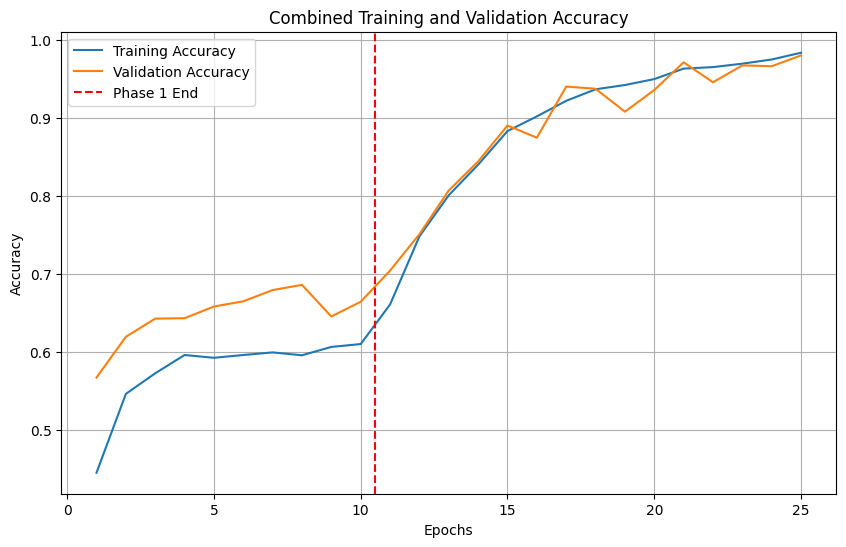

In [16]:
plot_combined_training_history([hist_phase1, hist_phase2], phase1_epochs=10)

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step


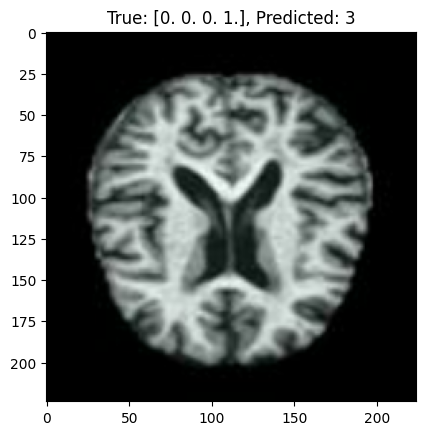

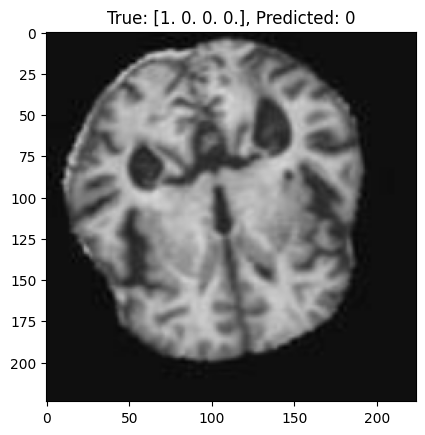

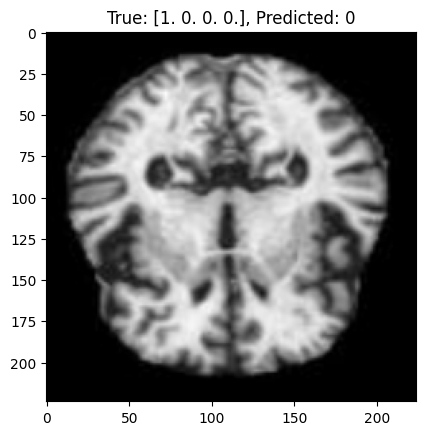

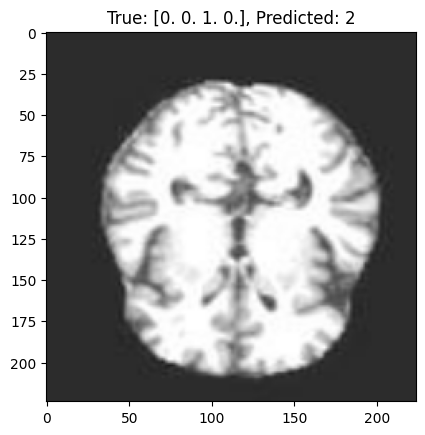

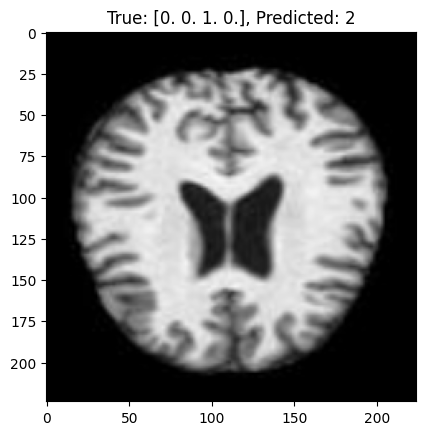

In [17]:
# Make predictions on test dataset
predictions = model.predict(ds_test)

# Visualize a few predictions
for images, labels in ds_test.take(1):
    for i in range(5):  # Display first 5 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {labels[i].numpy()}, Predicted: {tf.argmax(predictions[i])}")
        plt.show()

In [18]:
!pip install seaborn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

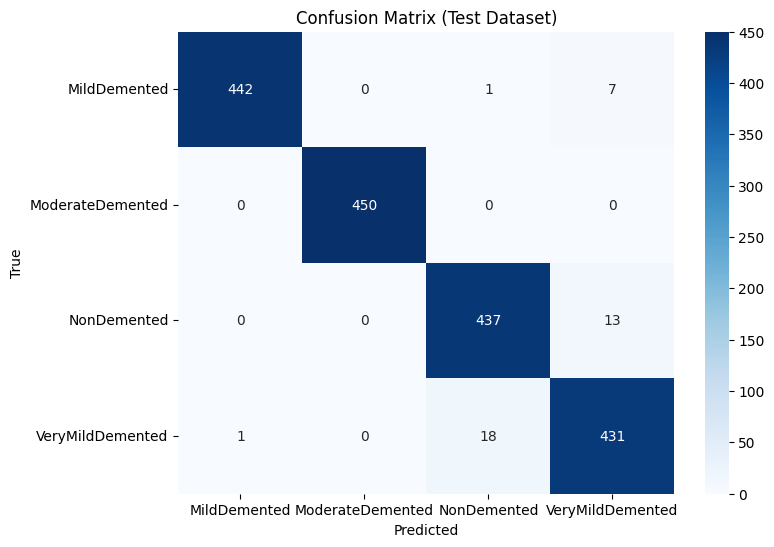


    Class: MildDemented
    TP: 442 | TN: 1349
    FP: 1 | FN: 8
    

    Class: ModerateDemented
    TP: 450 | TN: 1350
    FP: 0 | FN: 0
    

    Class: NonDemented
    TP: 437 | TN: 1331
    FP: 19 | FN: 13
    

    Class: VeryMildDemented
    TP: 431 | TN: 1330
    FP: 20 | FN: 19
    


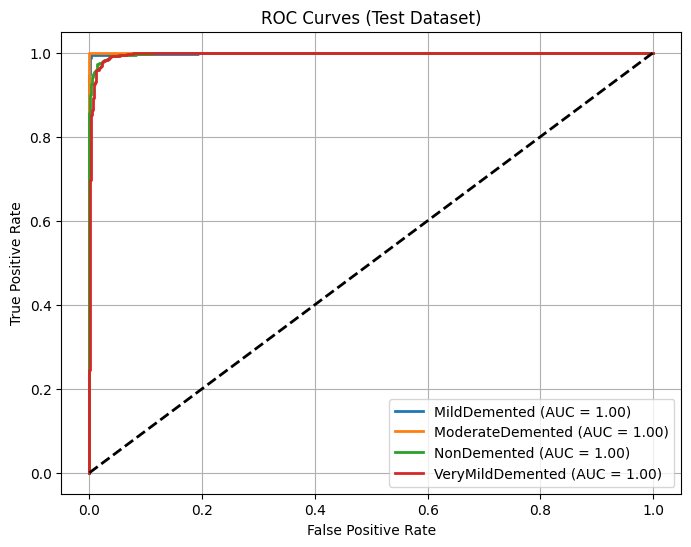

In [23]:
###UPDATED NEW CODE###
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Generate Predictions Batch by Batch for ds_test
y_true_test = []
y_pred_test = []

for images, labels in ds_test:
    y_true_test.extend(labels.numpy())  # Collect true labels batch by batch
    preds = model.predict(images)  # Predict batch by batch
    y_pred_test.extend(preds)

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

# Convert to class labels for ds_test
y_true_labels_test = np.argmax(y_true_test, axis=1)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

# Classification Report for ds_test
print("Classification Report (Test Dataset):")
print(classification_report(
    y_true_labels_test, 
    y_pred_labels_test, 
    target_names=class_names, 
    digits=5))


# Confusion Matrix for ds_test
cm_test = confusion_matrix(y_true_labels_test, y_pred_labels_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Dataset)")
plt.show()

for idx, class_name in enumerate(class_names):
    tp = cm_test[idx, idx] #diagonal element
    fn = np.sum(cm_test[idx, :]) - tp #row sum minus diagonal
    fp = np.sum(cm_test[:, idx]) - tp #column sum minus diagonal
    tn = np.sum(cm_test) - tp - fn - fp #everything else
    print(f"""
    Class: {class_name}
    TP: {tp} | TN: {tn}
    FP: {fp} | FN: {fn}
    """)

# Multi-Class ROC Curve (One-vs-Rest)
from sklearn.preprocessing import label_binarize

# Multi-Class ROC Curve (One-vs-Rest) for ds_test
y_true_bin_test = label_binarize(y_true_labels_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin_test[:, i], y_pred_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Dataset)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
